# Problem Definition
Using limit order book and executed trades data from the previous *WINDOW_LENGTH* seconds, identify whether a trade (long or short) placed now will return 25 basis points or more (before fees, slippage and other costs) in the next *HORIZON* seconds.

In this notebook we'll use a regression approach rather than a classification approach, so the task is not to predict extremely rare events, but to predict the future mid-price, which is arguably easier.

In [2]:
#Parameters. Predict HORIZON+1 seconds ahead, using previous LOOKBACK seconds of data.
LOOKBACK = 15
HORIZON = 30
THRESHOLD = 0.0025

# To-do:

There's some changes to be made following the discussion with Adrien:

* Instead of predicting prices, predict returns. I.e. instead of trying to predict what the price will be in 30 seconds, predict the 30s return on a trade placed right now. Stay with the 'regression' approach from v3; don't transform the target data into labels. Note, this doesn't mean that price can't be a feature in the input data, it just means that the target data are returns. 

* *Make* the dataset balanced by removing training examples with low return. Imagine cutting out the centre of a normal distribution, so the model can learn from the tails. 

* Plot histograms of all features and the response variable. We're checking that there's outliers and roughly gaussian distributions. Transformations or removal of outliers may be required (e.g. quantities are exponentially distributed; can try a log transform).

* **The whole art is in which features you build. The whole point of a complex model is that you build many features.**
    * Possible features are 1m, 30s, 15s returns; vwap; imbalance; crosseffects (product of volume and price, akak interaction effects in ST211).

* Find a way to use tradebook data.
---
## Could-do:
* Test the performance of a persistence model (using the last seen observation as the forecast)
* https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
---

Some (re)sources 
* http://karpathy.github.io/2019/04/25/recipe/
    * 'a “fast and furious” approach to training neural networks does not work and only leads to suffering. Now, suffering is a perfectly natural part of getting a neural network to work well, but it can be mitigated by being thorough, defensive, paranoid, and obsessed with visualizations of basically every possible thing. The qualities that in my experience correlate most strongly to success in deep learning are patience and attention to detail'
    
* DeepLOB.pdf and Ntakaris.pdf seem especially useful

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

plt.style.use('dark_background')

In [2]:
ob_train = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/train_orderbook.csv') #train orderbook
tb_train = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/train_trades.csv')#train tradebook

ob_test = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/test_orderbook.csv') #test orderbook 
tb_test = pd.read_csv('/Users/Sanjit/Repos/Predictive Analytics/test_trades.csv')#test tradebook 

In [3]:
ob_train

,timestamp,Seq_num,Exchange,symbol,timestamp.1,bid1,bidqty1,ask1,askqty1,bid2,...,ask8,askqty8,bid9,bidqty9,ask9,askqty9,bid10,bidqty10,ask10,askqty10
0,2021-03-06 21:05:12.648793,20210306210512699,huobipro,BTC/USDT,1615064712648793,48559.1278,0.0138,48561.5780,0.1150,48558.9978,...,48572.5485,0.1500,48556.0477,0.0300,48573.6786,0.1322,48555.9777,0.0250,48575.2686,0.0215
1,2021-03-06 21:05:13.656194,20210306210513658,huobipro,BTC/USDT,1615064713656194,48561.5280,0.1024,48561.5380,0.5263,48561.5180,...,48572.5485,0.1500,48556.0477,0.0300,48575.2686,0.0215,48555.9777,0.0250,48575.2886,0.8000
2,2021-03-06 21:05:14.855740,20210306210514856,huobipro,BTC/USDT,1615064714855740,48561.5280,0.0678,48561.5380,2.0378,48561.5180,...,48570.9084,0.1322,48556.0577,0.0300,48571.3484,0.0885,48556.0477,0.0300,48572.1585,0.0600
3,2021-03-06 21:05:15.705431,20210306210515706,huobipro,BTC/USDT,1615064715705431,48553.2075,0.0429,48553.2175,1.8027,48552.4775,...,48561.5280,0.0143,48550.0574,0.0400,48561.5380,1.4890,48546.7172,0.0004,48562.8680,0.0250
4,2021-03-06 21:05:16.729431,20210306210516730,huobipro,BTC/USDT,1615064716729431,48548.7473,0.0300,48548.7573,0.3864,48547.7673,...,48562.8480,0.1618,48537.8068,0.2000,48564.3781,1.2858,48536.6667,0.0400,48564.3881,0.0171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85365,2021-03-07 20:57:57.113335,20210307205757114,huobipro,BTC/USDT,1615150677113335,50044.7856,0.6329,50044.7956,0.1770,50044.7756,...,50053.7969,0.0200,50036.6144,0.0019,50054.5771,0.0600,50036.2443,0.0001,50055.9373,0.1322
85366,2021-03-07 20:57:58.151301,20210307205758152,huobipro,BTC/USDT,1615150678151301,50044.7856,0.1250,50044.7956,0.5329,50044.7756,...,50053.7969,0.0200,50036.2443,0.0001,50054.1070,0.0101,50035.2042,0.2000,50054.5771,0.0600
85367,2021-03-07 20:57:59.171845,20210307205759172,huobipro,BTC/USDT,1615150679171845,50044.7856,1.4817,50044.7956,0.2174,50044.7756,...,50056.1673,0.3200,50037.0044,0.7546,50056.3273,0.0599,50036.6944,0.0967,50056.6974,0.1522
85368,2021-03-07 20:58:00.228411,20210307205800229,huobipro,BTC/USDT,1615150680228411,50044.7856,1.6817,50044.7956,0.1470,50044.7756,...,50056.3273,0.0599,50036.9744,0.0100,50056.6974,0.1522,50036.6944,0.0967,50057.1975,0.0200


# Initial Data exploration
We only explore the training set. Peeking into the test set results in look-ahead bias.

## Limit order book

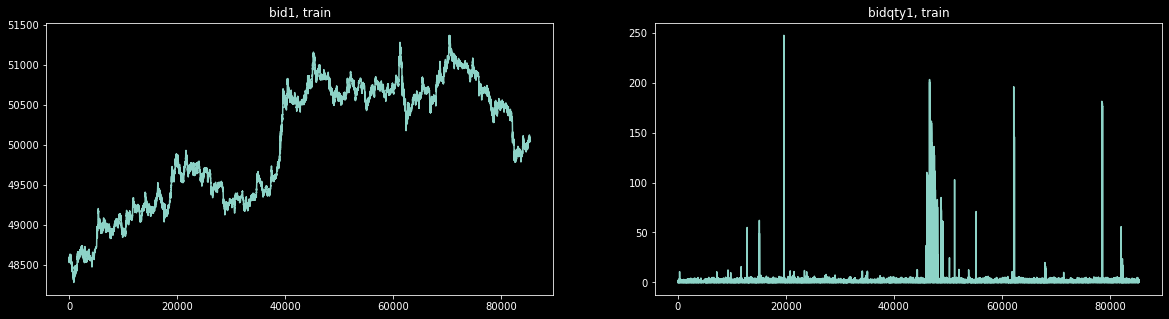

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title("bid1, train")
ax[0].plot(ob_train['bid1'])
ax[1].set_title("bidqty1, train")
ax[1].plot(ob_train['bidqty1'])

In [5]:
#time difference in seconds between consecutive rows of train orderbook
time_difference = np.diff(pd.to_datetime(ob_train['timestamp']).astype('int').to_numpy())/(1000000000)

print("Mean: ", np.mean(time_difference), "\nStandard deviation: ", np.std(time_difference))
print("Max: ", np.max(time_difference))

#There's a ~6 minute gap between row 68673 and 68674 of ob_train.
#Apart from this, the data is essentially contiguous, with a gap of 1 second between each row. 
#I'm assuming that this data has been processed to make the gap as it is

Mean:  1.007023328983589 
Standard deviation:  1.3061452462652685
Max:  381.767076


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

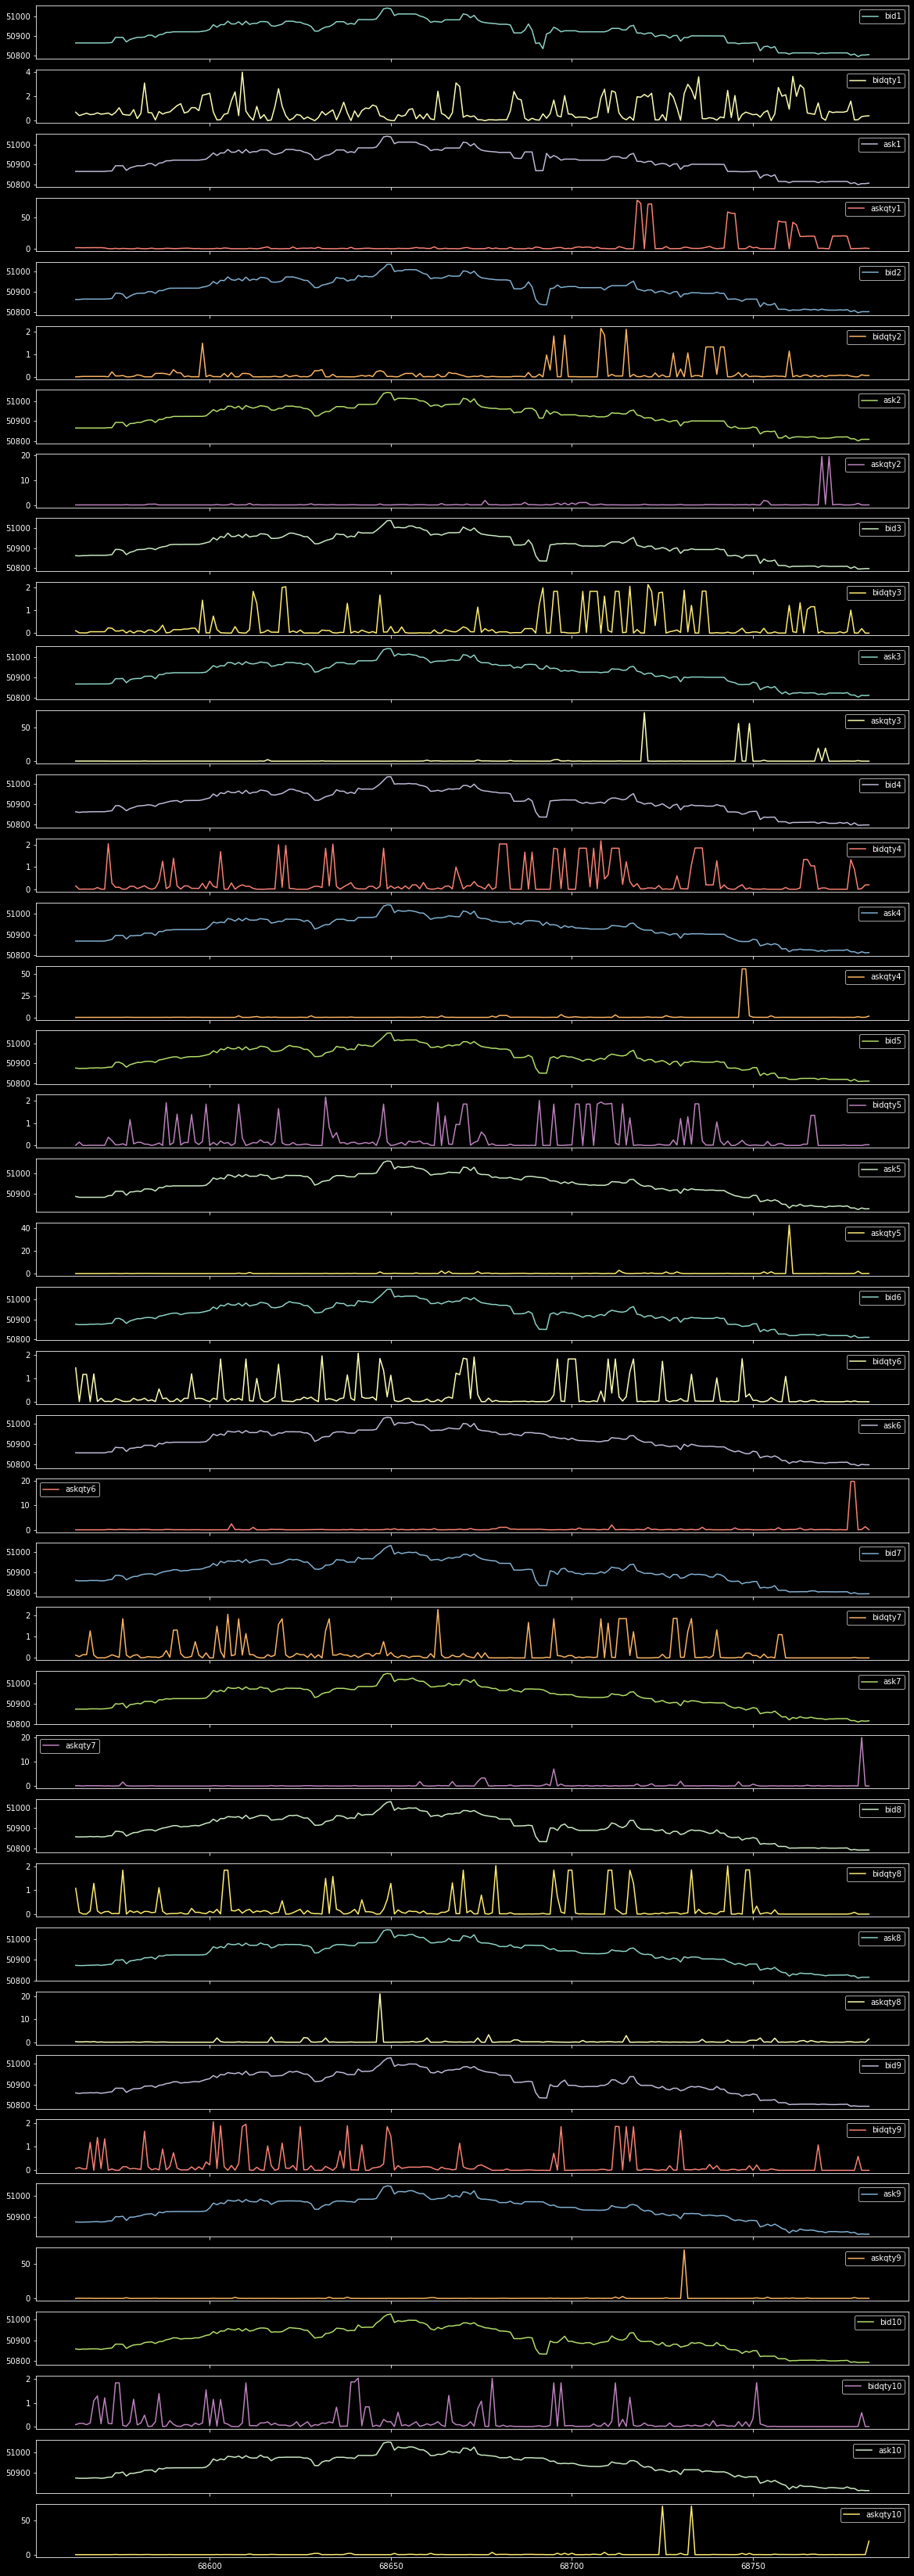

In [6]:
#Investing the 6 minute gap
ob_train[68563:68783].drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']).plot(subplots=True, figsize=(20, 60))
#Examining the time series around the point where this gap occurs, we can see that there's no obviously strange behaviour. 
#So, we can ignore this time gap. 

In [7]:
df1 = ob_train.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1'])[LOOKBACK-1:].pct_change(HORIZON)[HORIZON:]
#Rows of train where the price increase in horizon seconds was 0.25% or more, or the price decrease was -0.25% or less
#df1 = df1[(df1['bid1'] >= 0.0025) | (df1['bid1'] <= -0.0025)]
#print("Opportunities in train: ", len(df1))
print("Buy opportunities in train: ", np.sum([df1['bid1'] >= THRESHOLD]))
print("Sell opportunities in train", np.sum([df1['bid1'] <= -THRESHOLD]), "\n")

Buy opportunities in train:  238
Sell opportunities in train 160 



In [121]:
#Could-do: Get charts of HORIZON, LOOKBACK against number of trade opportunities. In deciding the value of HORIZON, there's a tradeoff between 
#predicting far into the future and having more trade opportunities.
#How do we represent this? HORIZON and LOOKBACK can both vary at the same time, so the plot must be 3D. 
#Possibly easier to represent in a table, so this is what I'll try
values = [1, 5, 10, 15, 20, 25, 30, 45, 60, 120]
v2 = np.array(values*len(values))
v1 = np.sort(v1)
tradeOpps = pd.DataFrame(np.hstack((v1.reshape(len(v1), 1), v2.reshape(len(v2), 1)))).rename(columns={0:"LOOKBACK", 1:"HORIZON"})
buyOpps = []
sellOpps = []

for i in range(len(tradeOpps)):
    l = tradeOpps.loc[i][0]
    h = tradeOpps.loc[i][1]
    df3 = ob_train.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1'])[l-1:].pct_change(h)[h:]
    buyOpps.append(np.sum([df3['bid1'] >= THRESHOLD]))
    sellOpps.append(np.sum([df3['bid1'] <= -THRESHOLD]))

tradeOpps['buyOpps'] = buyOpps
tradeOpps['sellOpps'] = sellOpps

Text(0.5, 0.92, 'Buy Opportunities')

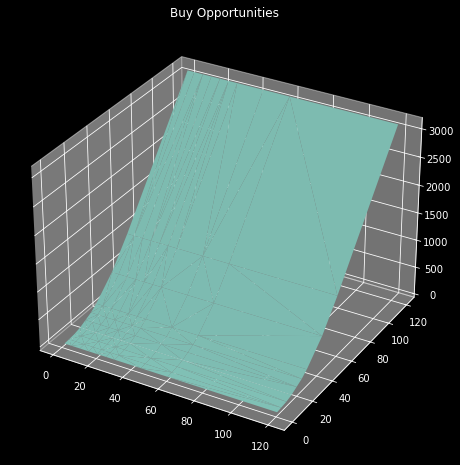

In [136]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
x = tradeOpps['LOOKBACK']
y = tradeOpps['HORIZON']
z = tradeOpps['buyOpps']
ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)
ax.set_title("Buy Opportunities")
#Nevermind, I have no idea why I thought LOOKBACK would affect trade opportunities. At least this was a good exercise.

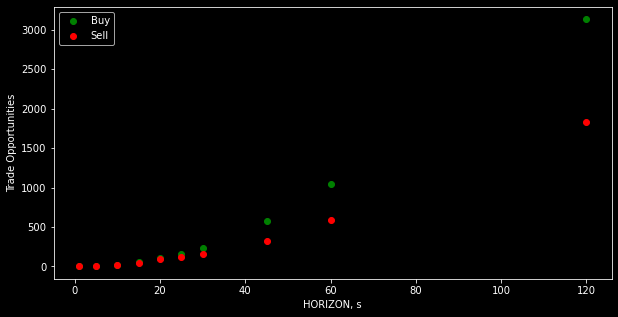

In [137]:
figure = plt.figure(figsize=(10, 5))
plt.plot(tradeOpps['HORIZON'][:10], tradeOpps['buyOpps'][:10], 'bo', color='Green')
plt.plot(tradeOpps['HORIZON'][:10], tradeOpps['sellOpps'][:10], 'bo', color='Red')
plt.ylabel('Trade Opportunities')
plt.xlabel('HORIZON, s')
plt.legend(['Buy', 'Sell'])

<AxesSubplot:title={'center':'Distribution of shorts'}, ylabel='Count'>

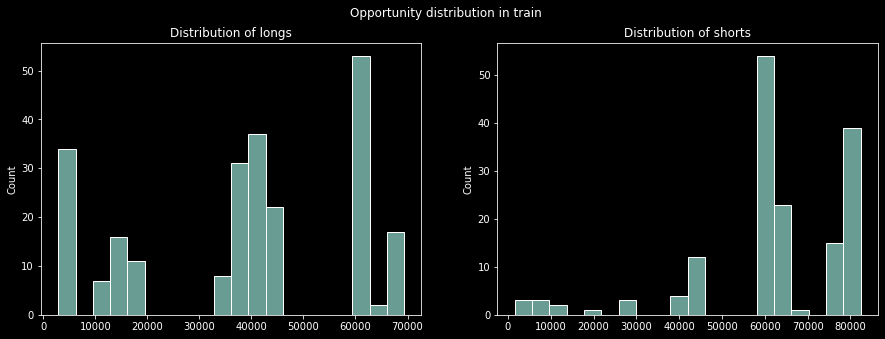

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Opportunity distribution in train")
ax[0].set_title("Distribution of longs")
sns.histplot(df1[df1['bid1'] >= THRESHOLD].index - HORIZON, bins=20, ax=ax[0])
ax[1].set_title("Distribution of shorts")
sns.histplot(df1[df1['bid1'] <= -THRESHOLD].index - HORIZON, bins=20, ax=ax[1])

#If we split into train into train and validation, there might be very few opportunities for shorts in the train set

<AxesSubplot:title={'center':'Correlations between variables'}>

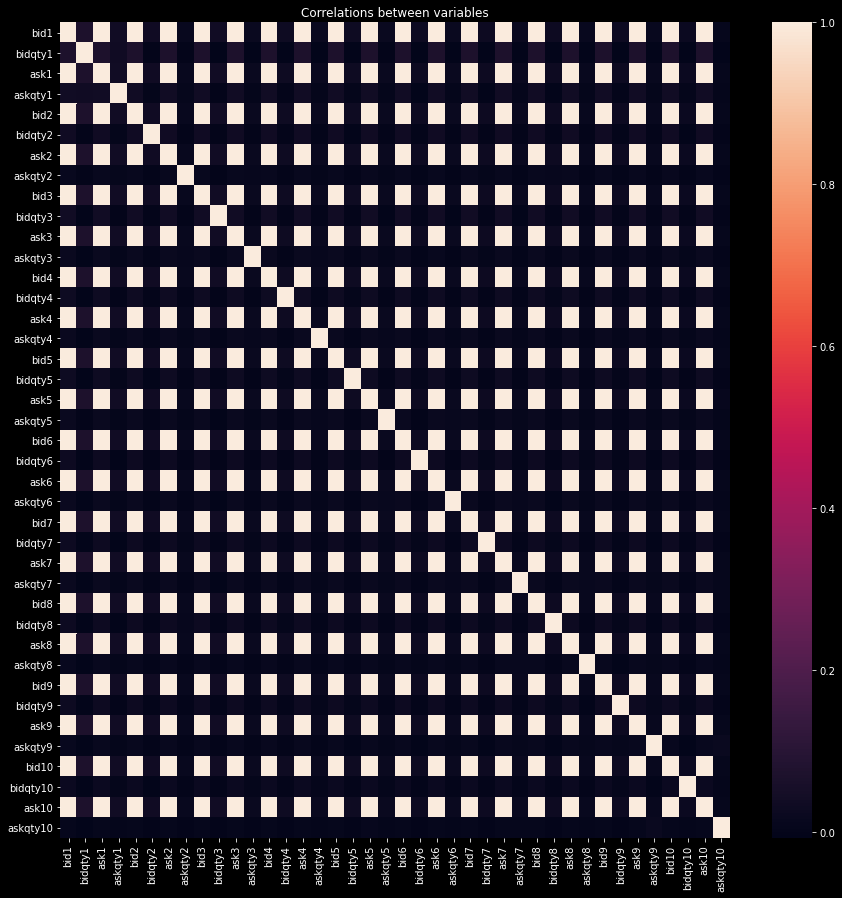

In [17]:
#Correlations between variables
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("Correlations between variables")
sns.heatmap(ob_train.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']).corr())

#Prices are perfectly correlated with each other, quantities are perfectly uncorrelated with every other variable
#as we might expect. Not very informative at all. 

<AxesSubplot:title={'center':'bid2'}, xlabel='bid2', ylabel='Count'>

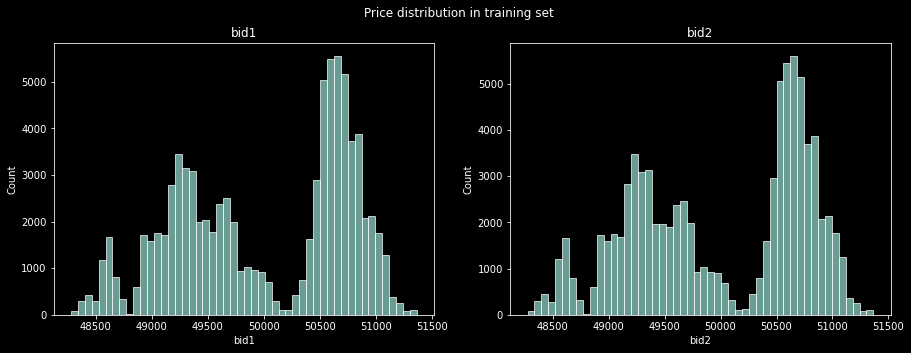

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Price distribution in training set")
ax[0].set_title("bid1")
sns.histplot(ob_train['bid1'], ax=ax[0], bins=50)
ax[1].set_title("bid2")
sns.histplot(ob_train['bid2'], ax=ax[1], bins=50)
#Not very normal, so raw price can't be used as a feature.
#No problem, we can use returns instead. 

<AxesSubplot:title={'center':'bid2'}, xlabel='bid2', ylabel='Count'>

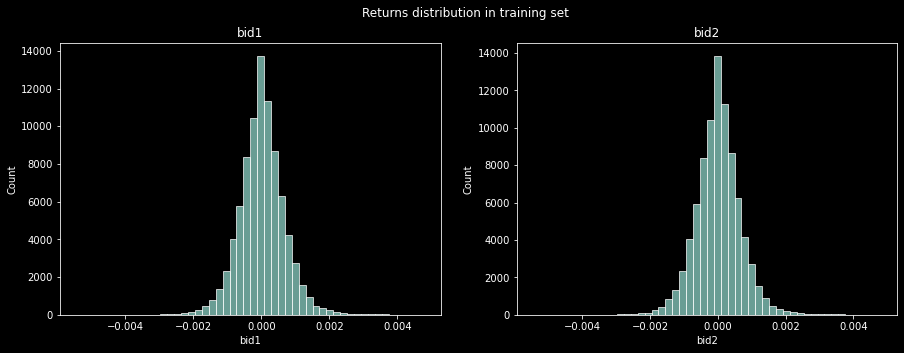

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Returns distribution in training set")
ax[0].set_title("bid1")
sns.histplot(df1['bid1'], ax=ax[0], bins=50)
ax[1].set_title("bid2")
sns.histplot(df1['bid2'], ax=ax[1], bins=50)
#Much better

"\nA trade of size 0.02 is approximately $1000 in cash terms, for this dataset.\n\nWe could potentially round down all trades of size 0.01 or less to 0, \ni.e. ignore them completely, assuming that:\n     1. it's unlikely that any small order can create a large price change of 25bp\n     2. it's unlikely that even a large number of small orders can cause price to jump\nThe first assumption is plausible, the second is not\nE.g. a string of 1000 small sell market orders will probably cause price to fall\n\nIn any case, what actually is bidqty1 in ob_train? \n    It is the quantities of the highest submitted buy limit orders\nA possible feature then is the change in bidqty1 over the last 1, 5, 10 seconds\nOr the change in the sum of bid quantities over the last 1, 5, 10 seconds \n\nLimit orders are passive though. It seems that market orders are more informative\nAnother possible feature is change in buy volume over the last 1, 5, 10 seconds\n"

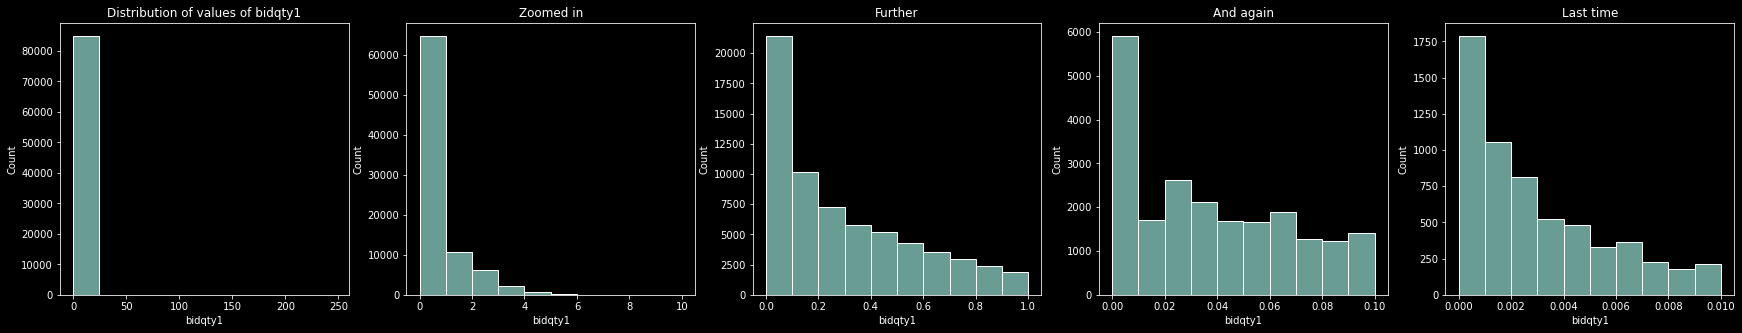

In [139]:
fig, ax = plt.subplots(1, 5, figsize=(30, 5))
ax[0].set_title("Distribution of values of bidqty1")
sns.histplot(ob_train['bidqty1'], bins=10, ax=ax[0])
ax[1].set_title("Zoomed in")
sns.histplot(ob_train['bidqty1'], bins=10, binrange=(0, 10), ax=ax[1])
ax[2].set_title("Further")
sns.histplot(ob_train['bidqty1'], bins=10, binrange=(0, 1), ax=ax[2])
ax[3].set_title("And again")
sns.histplot(ob_train['bidqty1'], bins=10, binrange=(0, 0.1), ax=ax[3])
ax[4].set_title("Last time")
sns.histplot(ob_train['bidqty1'], bins=10, binrange=(0, 0.01), ax=ax[4])
'''
A trade of size 0.02 is approximately $1000 in cash terms, for this dataset.

We could potentially round down all trades of size 0.01 or less to 0, 
i.e. ignore them completely, assuming that:
     1. it's unlikely that any small order can create a large price change of 25bp
     2. it's unlikely that even a large number of small orders can cause price to jump
The first assumption is plausible, the second is not
    E.g. a string of 1000 small sell market orders will probably cause price to fall
    Needs exploration, can plot buy volume over last 1, 5, 10 second blocks over time

In any case, what actually is bidqty1 in ob_train? 
    It is the quantities of the highest submitted buy limit orders
A possible feature then is the change in bidqty1 over the last 1, 5, 10 seconds
Or better, the change in the sum of bid quantities over the last 1, 5, 10 seconds 

Limit orders are passive though. It seems that market orders are more informative
Another possible feature is change in buy volume over the last 1, 5, 10 seconds
'''

<AxesSubplot:title={'center':'Zoomed in'}, ylabel='Count'>

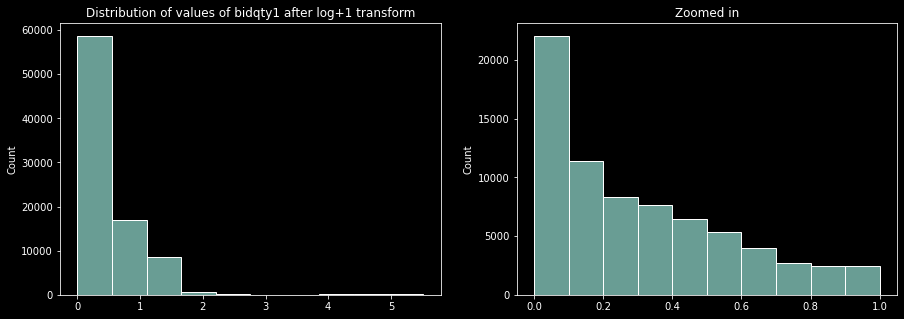

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("Distribution of values of bidqty1 after log+1 transform")
sns.histplot(np.log(np.array(ob_train['bidqty1'])+1), bins=10, ax=ax[0])
ax[1].set_title("Zoomed in")
sns.histplot(np.log(np.array(ob_train['bidqty1'])+1), bins=10, binrange=(0, 1), ax=ax[1])
#Quantity is not a suitable feature

## Tradebook

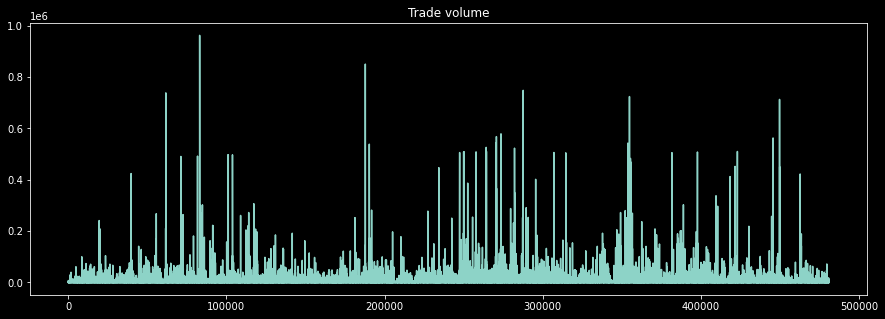

In [56]:
volume = tb_train['price'] * tb_train['quantity']
plt.figure(figsize=(15, 5))
plt.title("Trade volume")
plt.plot(volume)

<AxesSubplot:title={'center':'Zoomed in'}, ylabel='Count'>

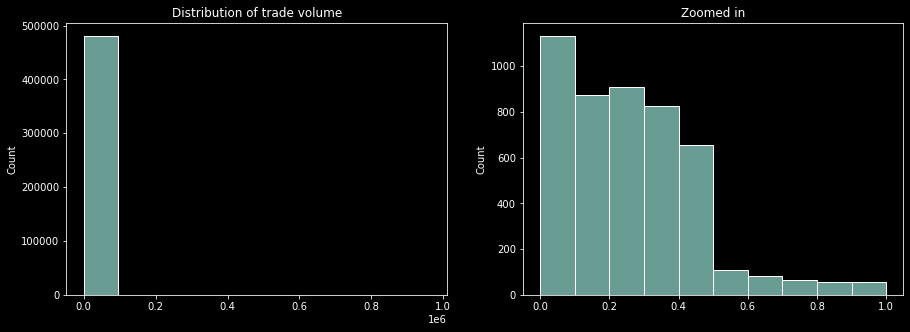

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("Distribution of trade volume")
sns.histplot(volume, bins=10, ax=ax[0])
ax[1].set_title("Zoomed in")
sns.histplot(volume, bins=10, binrange=(0, 1), ax=ax[1])

<AxesSubplot:title={'center':'Zoomed in'}, ylabel='Count'>

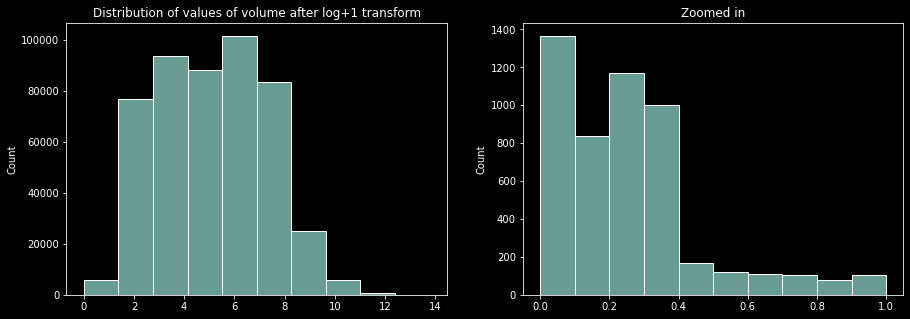

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("Distribution of values of volume after log+1 transform")
sns.histplot(np.log(volume+1), bins=10, ax=ax[0])
ax[1].set_title("Zoomed in")
sns.histplot(np.log(volume+1), bins=10, binrange=(0, 1), ax=ax[1])
#Surprisngly close to normal

# Data Cleaning
* Convert timestamps from str to datetime
* We are ignoring the ~6 minute gap between row 68673 and 68674 of ob_train, so remove corresponding entries in tb_train.
* For convenience when building features, we resample ob_train so that each timestamp is a whole second. 

In [5]:
#Convert timestamps from str to datetime
ob_train['timestamp'] = pd.to_datetime(ob_train['timestamp'])
tb_train['system_datetime'] = pd.to_datetime(tb_train['system_datetime'])
ob_test['timestamp'] = pd.to_datetime(ob_test['timestamp'])
tb_test['system_datetime'] = pd.to_datetime(tb_test['system_datetime'])

In [6]:
#We are ignoring the ~6 minute gap between row 68673 and 68674 of ob_train.
#So remove corresponding entries in tb_train.
gap_start = pd.to_datetime(ob_train.iloc[68673, :][0])
gap_end = pd.to_datetime(ob_train.iloc[68674, :][0])

indexes = []
for i in range(len(tb_train['system_datetime'])):
    if tb_train['system_datetime'][i] > gap_start and tb_train['system_datetime'][i] < gap_end:
        indexes.append(i)

tb_train = tb_train.drop(indexes)

In [7]:
#using the .describe() method, we can see that resampling doesn't change the underlying data much, if at all.
ob_train = ob_train.set_index('timestamp').resample('1S').mean().reset_index()
ob_test = ob_test.set_index('timestamp').resample('1S').mean().reset_index()
'''
During live trading we can group incoming data by the second to build the necesssary features. 

When backtesting, remember not to use data from the current second, since it contains
information up till the end of the current second. Using it may introduce look-ahead bias. 
'''

'\nDuring live trading we can group incoming data by the second to build the necesssary features. \n\nWhen backtesting, remember not to use data from the current second, since it contains\ninformation up till the end of the current second. Using it may introduce look-ahead bias. \n'

# Feature Engineering
Before reading the papers, some features that we could add/remove from the data we have:

Orderbook:
* Use 30s return on a trade placed now as the target data instead of price (for regression model, this is already the case for the classification model)
* The previous LOOKBACK 1m returns, 30s returns, 15s returns, 5s returns, 1s returns. E.g. if *LOOKBACK* = 10, then we have 1m return on trades placed 1m, 1m1s, ..., 1m9s ago; 30s return on trades placed 30s, 31s, ..., 39s ago; 15s returns on trades placed 15s, ..., 24s ago; and so on. 

Tradebook:
* Pseudo-volatility / volume feature which is high when there are many large volume trades placed recently, and is low otherwise (using tradebook data)

Features from alternative data sources:
* Changes in bitcoin mining costs (see orange tagged papers)
* Sentiment indicators
* See https://www.reddit.com/r/Bitcoin/comments/c1r9yc/cryptocurrency_alternative_data_apis/


In [8]:
#Make copies to build other features from
ob_train_raw = ob_train.copy()
ob_test_raw = ob_test.copy()
#Keep only the top N levels of the limit order book, since most of the signal is contained in the top level.
N = 2
ob_train = ob_train.iloc[:, :(3+N*4)]
ob_test = ob_test.iloc[:, :(3+N*4)]

## Custom features
* Could round down trade quantities less than 0.01 to 0, i.e. drop these rows from the tradebook.
    * This is equivalent to ignoring trades of value less than $500. The rationale is that large price jumps are more often than not caused by large orders. An obvious counterexample is a large number of small orders on one side, with little interest from the other side. 
    * A more general rationale then, is that large price jumps are preceded by a large imbalance between total buy and sell volume in the last few seconds in the tradebook. 
    * This suggests a few features: 
        * n-second imbalance, defined as the sum of buy volume minus the sum of sell volume over the last n seconds
        * change in n-second imbalance over the last m seconds 
        * Not the sums of n-second buy volume or sell volume, as these won't be normally distributed. But possibly the change in n-second buy volume or sell volume. 
            * Similar features for orderbook data. In a way, the tradebook is backward-looking, and the orderbook is forward-looking. 
* Could include moving averages of price, as one of the papers mentioned benefits to 'smoothing' the price series. But the feature still won't be normally distributed. Moving averages of returns are obviously useless. 
* Including returns of askn is redundant because we are assuming that we can enter and exit trades at the bid price. However, we could include the spread with bidn. I imagine it won't be normally distributed, so the 1, 5, 10s change in spread may be more appropriate. 
---
Adrien specialises in linear models, so its worth checking whether LSTMs can deal with non-normal data. I don't see a way to transform spread into a normal feature, and it does seem informative. 

In [9]:
def add_custom_features(df1, df2):
    for column in df1.drop(columns=['timestamp', 'Seq_num', 'timestamp.1']):
        if 'qty' not in column:
            for t in [1, 5, 10, 15, 30, 60]:
                df1[column + '_' + str(t) + 's_ret'] = df1.drop(columns=['timestamp', 'Seq_num', 'timestamp.1']).pct_change(t)[column]
    
    return df1

ob_train = add_custom_features(ob_train, tb_train)
ob_test = add_custom_features(ob_test, tb_test)

## Machine_Learning_for_Forecasting_Mid_Price_Movement.pdf
See Table 4 on Page 13 of https://arxiv.org/pdf/1705.03233.pdf (reference 32 in the paper). 

See Page 16 of https://www.math.fsu.edu/~aluffi/archive/paper462.pdf for a description of time-sensitive features.

* Note: the goal of this paper is to predict the mid-price movement but we want to predict returns . The other concern is that they didn't use LSTMs, but instead a less complex classification algorithm. 

In [8]:
#Add time-insensitive features
def add_ti_features(df):

    u_5_1 = len(df) * [0]
    u_5_2 = len(df) * [0]

    for i in range(1, N+1):
        df['spread' + str(i)] = df['ask' + str(i)] - df['bid' + str(i)] #spread
        df['mid' + str(i)] = (df['ask' + str(i)] + df['bid' + str(i)]) / 2 #mid

        if i < N:
            df['u3_3_' + str(i+1) + "-" + str(i)] = np.abs(df['ask' + str(i+1)] - df['ask' + str(i)])
            df['u3_4_' + str(i+1) + "-" + str(i)] = np.abs(df['bid' + str(i+1)] - df['bid' + str(i)])

        u_5_1 += df['ask' + str(i)] - df['bid' + str(i)]
        u_5_2 += df['askqty' + str(i)] - df['bidqty' + str(i)]

    df['u3_1'] = df['ask' + str(N)] - df['ask1']
    df['u3_2'] = df['bid1'] - df['bid' + str(N)]

    df['ask_mean'] = df[[x for x in df.columns if x.startswith('ask') and "qty" not in x]].mean(axis=1) / N
    df['bid_mean'] = df[[x for x in df.columns if x.startswith('bid') and "qty" not in x]].mean(axis=1) / N
    df['askqty_mean'] = df[[x for x in df.columns if x.startswith('askqty')]].mean(axis=1) / N
    df['bidqty_mean'] = df[[x for x in df.columns if x.startswith('bidqty')]].mean(axis=1) / N

    return df

ob_train = add_ti_features(ob_train)
ob_test = add_ti_features(ob_test)
print(ob_train.shape, ob_test.shape)

(85970, 33) (85971, 33)


In [9]:
#Preparing to add time-sensitive features
def map_sell(x):
    if x == "sell":
        return 1
    else:
        return 0
    
def map_buy(x):
    if x == "buy":
        return 1
    else: 
        return 0

tb_train['sell'] = tb_train['side'].apply(lambda x: map_sell(x))
tb_train['buy'] =  tb_train['side'].apply(lambda x: map_buy(x))
tb_test['sell'] = tb_test['side'].apply(lambda x: map_sell(x))
tb_test['buy'] =  tb_test['side'].apply(lambda x: map_buy(x))

#The first timestamp in ob_train is 2021-03-06 21:05:12.6 (before resampling)
#So we remove the first few rows of tb_train
tb_train = tb_train.loc[2789:, :]

In [10]:
def add_ts_features(df1, df2):
    for i in range(1, N+1):
        #Change over the last second
        df1['u6_1' + str(i)] = df1['ask' + str(i)].diff() 
        df1['u6_2' + str(i)] = df1['bid' + str(i)].diff()
        df1['u6_3' + str(i)] = df1['askqty' + str(i)].diff()
        df1['u6_4' + str(i)] = df1['bidqty' + str(i)].diff()
    
    #df1['u7_a'] = df2.set_index('system_datetime').resample('1S').sum().reset_index()['sell']
    #df1['u7_b'] = df2.set_index('system_datetime').resample('1S').sum().reset_index()['buy']

    #Distribution of u7, u8 features is clearly non-normal

    df1['u9_a'] = df2.set_index('system_datetime').resample('1S').sum().reset_index().iloc[:, 5:].pct_change()['sell']
    df1['u9_b'] = df2.set_index('system_datetime').resample('1S').sum().reset_index().iloc[:, 5:].pct_change()['buy']

    return df1

ob_train = add_ts_features(ob_train, tb_train)
ob_test = add_ts_features(ob_test, tb_test)
print(ob_train.shape, ob_test.shape)

(85970, 47) (85971, 47)


## Scatterplot

<AxesSubplot:title={'center':'Correlations between variables'}>

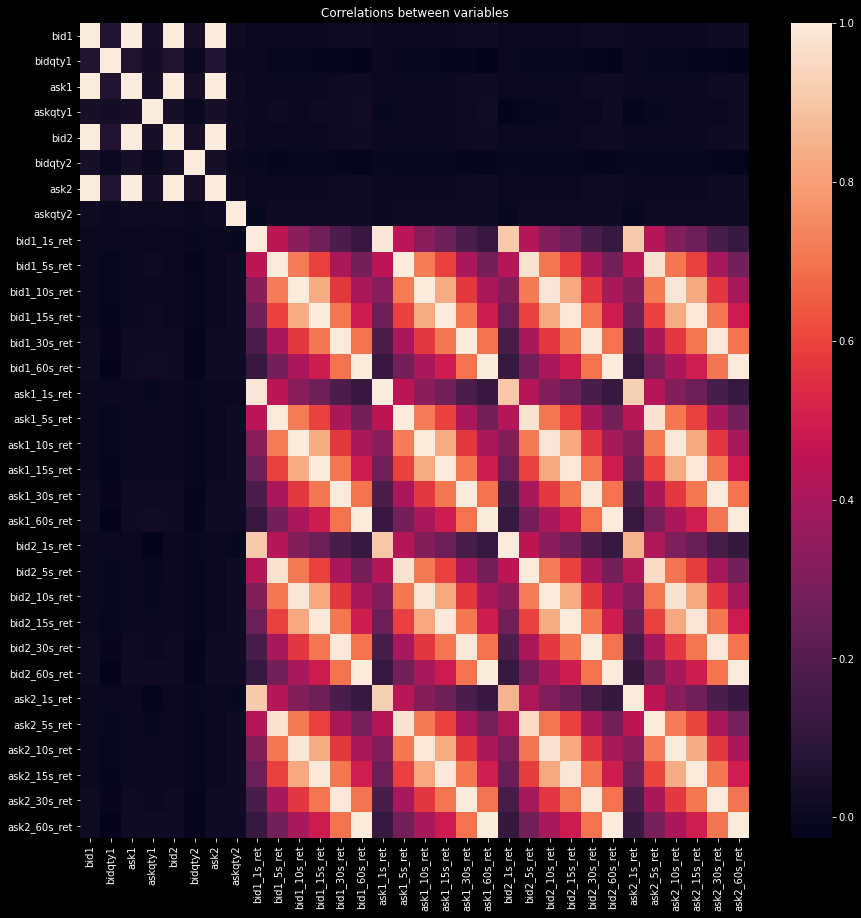

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("Correlations between variables")
sns.heatmap(ob_train.drop(columns=['timestamp', 'Seq_num', 'timestamp.1']).corr())

## Removing non-normal features

array([[<AxesSubplot:title={'center':'bid1'}>,
        <AxesSubplot:title={'center':'bidqty1'}>,
        <AxesSubplot:title={'center':'ask1'}>,
        <AxesSubplot:title={'center':'askqty1'}>,
        <AxesSubplot:title={'center':'bid2'}>,
        <AxesSubplot:title={'center':'bidqty2'}>,
        <AxesSubplot:title={'center':'ask2'}>],
       [<AxesSubplot:title={'center':'askqty2'}>,
        <AxesSubplot:title={'center':'bid3'}>,
        <AxesSubplot:title={'center':'bidqty3'}>,
        <AxesSubplot:title={'center':'ask3'}>,
        <AxesSubplot:title={'center':'askqty3'}>,
        <AxesSubplot:title={'center':'bid4'}>,
        <AxesSubplot:title={'center':'bidqty4'}>],
       [<AxesSubplot:title={'center':'spread1'}>,
        <AxesSubplot:title={'center':'mid1'}>,
        <AxesSubplot:title={'center':'u3_3_2-1'}>,
        <AxesSubplot:title={'center':'u3_4_2-1'}>,
        <AxesSubplot:title={'center':'spread2'}>,
        <AxesSubplot:title={'center':'mid2'}>,
        <AxesSubplot:ti

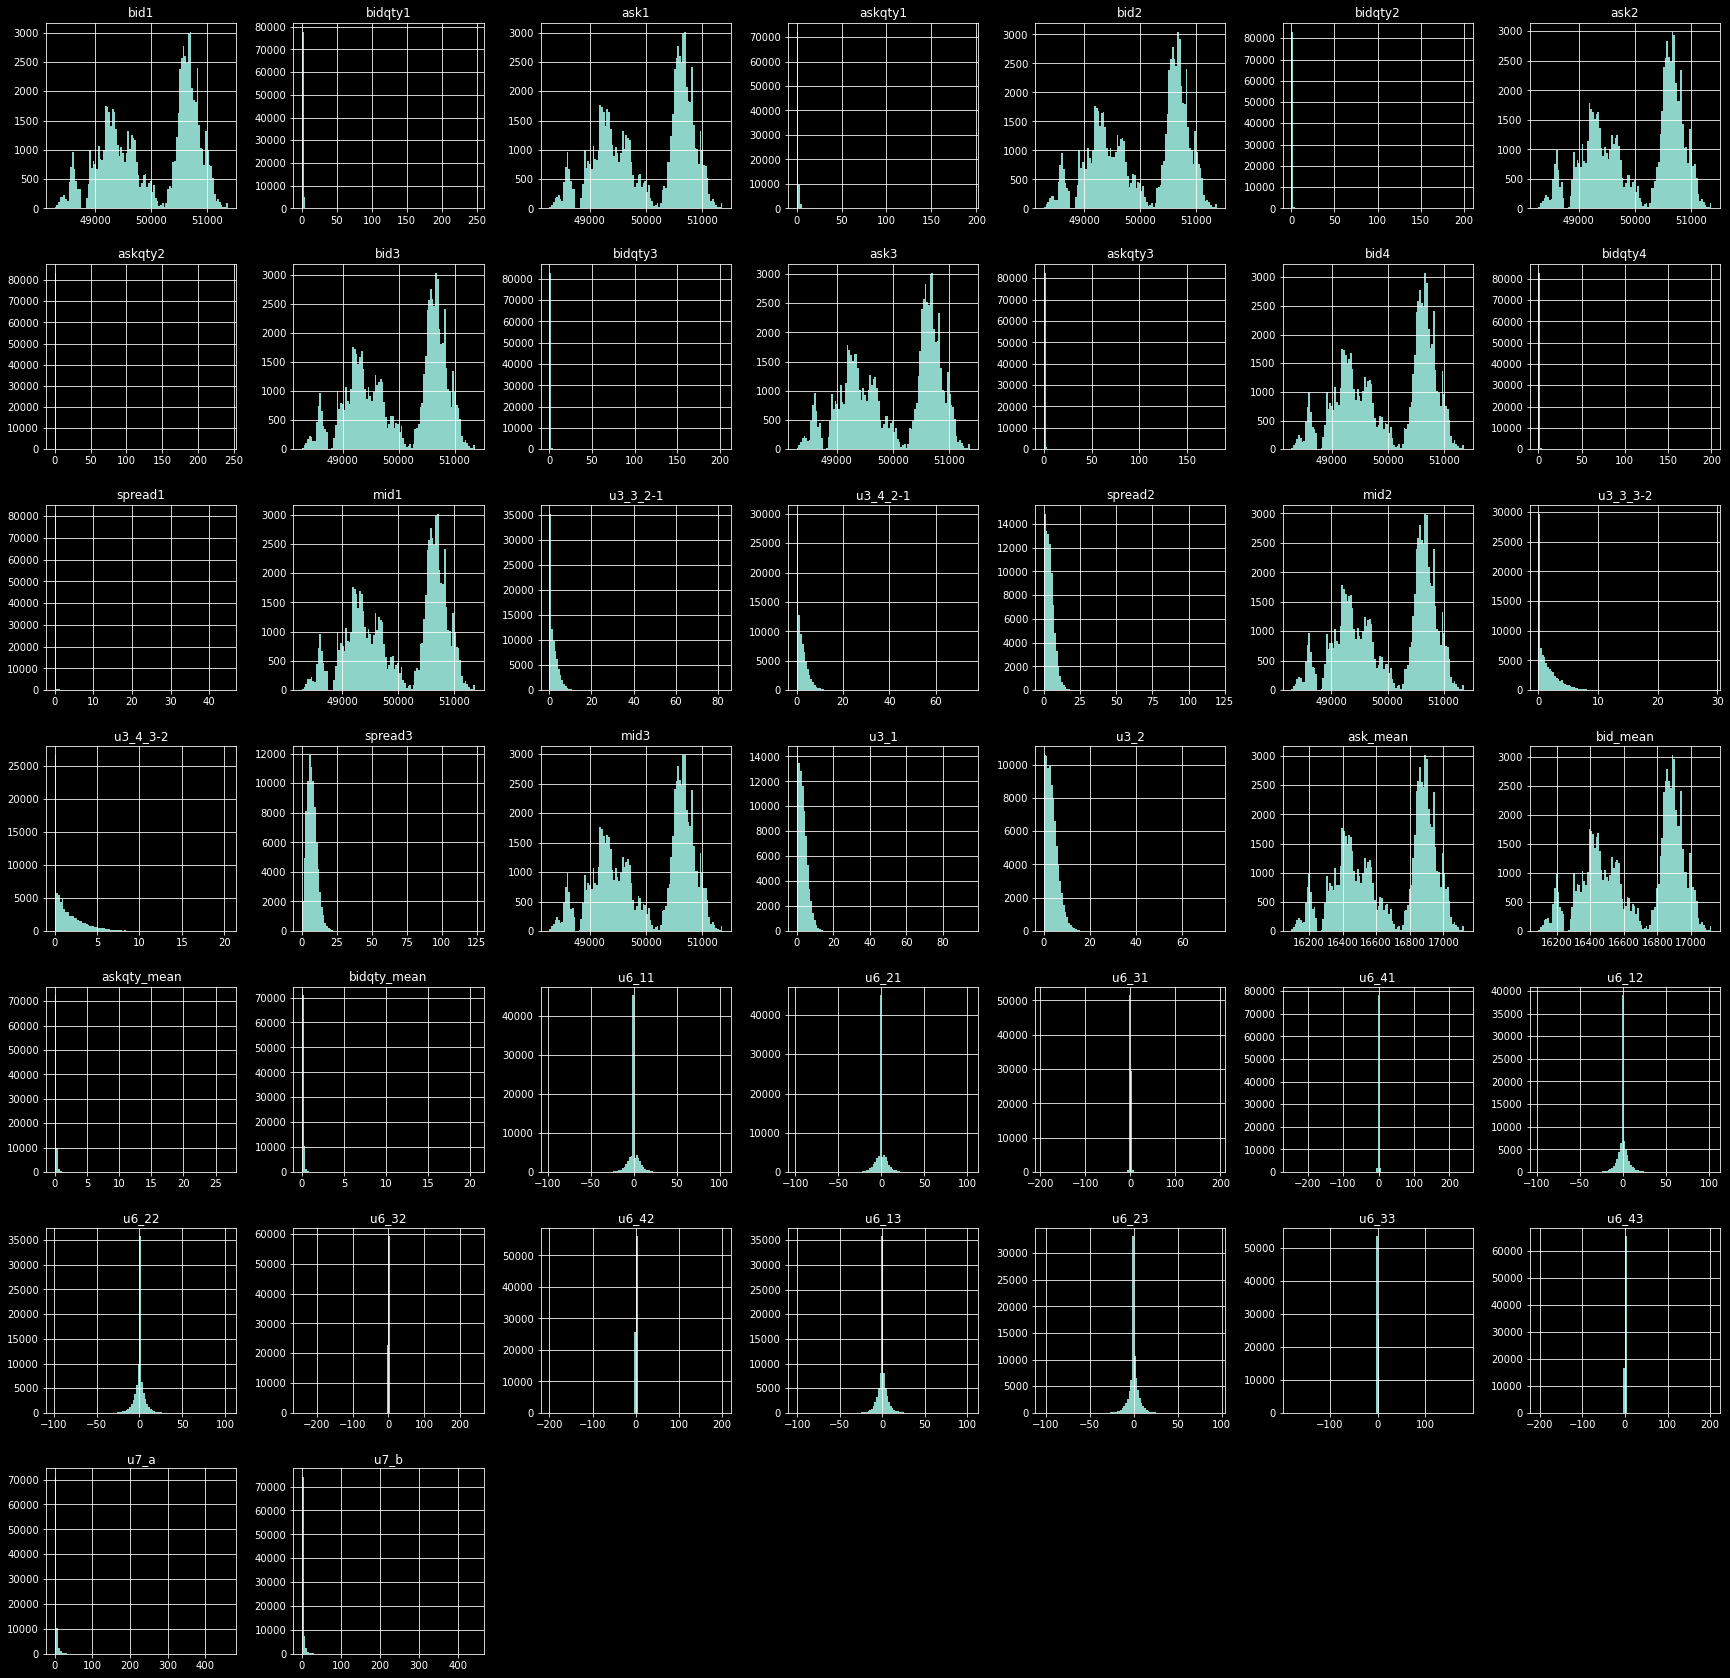

In [19]:
ob_train.drop(columns=['timestamp', 'timestamp.1', 'Seq_num']).hist(bins=100, figsize=(30, 30))

In [40]:
#Drop quantity non-normal features
columns = []
for i in range(1, N+1):
    columns.append('bidqty' + str(i))
    columns.append('askqty' + str(i))
    
ob_train = ob_train.drop(columns=columns)
ob_test = ob_test_ret.drop(columns=columns)

KeyError: "['bidqty3' 'askqty3'] not found in axis"

# Preprocessing

## Split
Need to split before scaling, to ensure that information from the validation set is not leaking into the training set.

In [10]:
ob_train_ret, ob_val_ret = train_test_split(ob_train_ret, test_size=0.2, shuffle=False)

## Scaling

Source: https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/

Standardise prices. Normalisation is not suitable, since the time series may trend up or down. Standardisation is also required when data are of different scales; price and volume certainly are of different scales so this is the case.

Assumptions:
* Standardisation requires that you know or are able to accurately estimate the mean and standard deviation of observable values. 
* Standardisation assumes that observations fit a Gaussian distribution:
    * The plot above shows that this doesn't really hold for the prices
    * It certainly doesn't hold for the quantities. So, quantities need to be normalised instead.

Need to normalise new data in the same way as old data, so save scalers and use them on the test set.

---

Scaling is unnecessary if we're working with returns instead of prices. 

In [11]:
#Need to normalise new data in the same way as old data, so use the scaler fit on the training set to scale validation and test sets.
#In the DeepLOB paper it seems that they scale the entire orderbook using a single scaler, so we'll try the same.

def fit_and_scale(df):
    df = df.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']).to_numpy()
    scaler = StandardScaler()
    scaler.fit(df)
    df = scaler.transform(df)
    return df, scaler

def scale_new(df, scaler):
    df = df.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1']).to_numpy()
    df = scaler.transform(df)
    return df

train_lob, scaler = fit_and_scale(ob_train_train)
val_lob = scale_new(ob_val, scaler)
test_lob = scale_new(ob_test, scaler)

NameError: name 'ob_train_train' is not defined

## Building dataset

Our 'X' data will be the previous **window_length** rows (including the current one) of the the feature set. The 'y' data will be bid1 in the **horizon**th row below the last row of the 'X' data. 

In [12]:
#Source: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
#Drop irrelevant columns
#Reshape data into the shape (batch_size, window_length, features), where batch_size is the maximum possible batch size. 
#The shape of one single sample with window_length=5 and features=40 is (1, 5, 40)
'''
raw: 10, 20, 30, 40, 50, 60

            X				y
Example 1   10, 20, 30		40 
Example 2   20, 30, 40		50 
Example 3   30, 40, 50		60 
'''
def build_ds_regression(raw, window_length, horizon):
    #raw = raw.drop(columns=['timestamp', 'Seq_num', 'Exchange', 'symbol', 'timestamp.1'])
    ds = raw.to_numpy()
    X = []
    y = []
    for i in range(len(ds) - window_length - horizon):
        X_instance, y_instance = ds[i:i+window_length, :], ds[i+window_length+horizon:i+window_length+horizon+1, 0]
        X.append(X_instance)
        y.append(y_instance)
    X = np.array(X)
    y = np.array(y) 
    return X, y

In [13]:
#LOOKBACK is time_steps in existing literature. Each prediction is based on the previous window_length rows. Has been set above.

X_train, y_train = build_ds_regression(ob_train_ret, LOOKBACK, HORIZON-1)
print(X_train.shape, y_train.shape)

X_val, y_val = build_ds_regression(ob_val_ret, LOOKBACK, HORIZON-1) #Surely we shouldn't peek into the validation set?
print(X_val.shape, y_val.shape)

X_test, y_test = build_ds_regression(ob_test_ret, LOOKBACK, HORIZON-1)
print(X_test.shape, y_test.shape)

(68228, 15, 6) (68228, 1)
(17024, 15, 6) (17024, 1)
(84239, 15, 6) (84239, 1)


# Training
We first train a baseline model (for comparison with a trained model), and then actually train a model.


In [14]:
#See https://machinelearningmastery.com/regression-metrics-for-machine-learning/
METRICS = [
      keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),
      keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None),
      keras.metrics.MeanAbsolutePercentageError(name="mean_absolute_percentage_error", dtype=None), 
      keras.metrics.MeanSquaredLogarithmicError(name="mean_squared_logarithmic_error", dtype=None),
      keras.metrics.CosineSimilarity(name="cosine_similarity", dtype=None, axis=-1),
      keras.metrics.LogCoshError(name="logcosh", dtype=None),
]

def build_regression_model(learning_rate=0.001, window_length=LOOKBACK, n_features=X_train.shape[2]):
    model = keras.Sequential() #Don't need to do sequential model 
    model.add(layers.LSTM(100, activation='relu', input_shape=(window_length, n_features)))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(y_train.shape[1], activation='linear')) #We want the model to output a real vector, all entries are predictions of bid1 at different timesteps.

    #Compile model
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate) #Try stochastic gradient descent as well
    model.compile(loss='mean_squared_error', optimizer = opt, metrics=METRICS) 
    return model

In [15]:
EPOCHS = 5
BATCH_SIZE = 32

# Create a callback that saves the model's weights
model_name = f"baseline_h1_bs{BATCH_SIZE}_e{EPOCHS}"
checkpoint_path = f"/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/v4/{model_name}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    save_weights_only=True, 
    verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = build_regression_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               42800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Model statistics before training, on training set
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))
for i in range(len(results)-1):
    print(METRICS[i].name, ": {:0.4f}".format(results[i+1]))

In [32]:
save_weights = True

if save_weights:
    history = model.fit(
        X_train, 
        y_train, 
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        shuffle=False, 
        callbacks=[cp_callback, early_stopping],
        verbose=1)
else:
    history = model.fit(
        X_train, 
        y_train, 
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        shuffle=False, 
        callbacks=[early_stopping],
        verbose=1)

Epoch 1/5
2133/2134 [============================>.] - ETA: 0s - loss: 3.0237e-08 - root_mean_squared_error: 1.5039e-04 - mean_absolute_error: 7.9549e-05 - mean_absolute_percentage_error: 11392.4336 - mean_squared_logarithmic_error: 1.2077e-08 - cosine_similarity: 0.0119 - logcosh: 1.3439e-08
Epoch 00001: saving model to /Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/v4/baseline_h1_bs32_e5.ckpt
2134/2134 [==============================] - 44s 21ms/step - loss: 3.0234e-08 - root_mean_squared_error: 1.5039e-04 - mean_absolute_error: 7.9559e-05 - mean_absolute_percentage_error: 11402.1885 - mean_squared_logarithmic_error: 1.2076e-08 - cosine_similarity: 0.0118 - logcosh: 1.3438e-08 - val_loss: 1.6316e-08 - val_root_mean_squared_error: 1.2774e-04 - val_mean_absolute_error: 7.4214e-05 - val_mean_absolute_percentage_error: 6975.5737 - val_mean_squared_logarithmic_error: 7.7510e-09 - val_cosine_similarity: -0.0068 - val_logcosh: 9.3295e-09
Epoch 2/5
2134/2134 [====================

In [ ]:
#Model statistics after training, on training set
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))
for i in range(len(results)-1):
    print(METRICS[i].name, ": {:0.4f}".format(results[i+1]))

In [33]:
#Convert the history.history dict to a pandas DataFrame and save to csv
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv(f"/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/v4/{model_name}.csv")

# Evaluation

## Training

In [16]:
history = pd.read_csv(f"/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/v4/{model_name}.csv")
#history = pd.read_csv(f"/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/v4/baseline3_bs32_e5.csv")

Text(0.5, 1.0, 'Red: loss during training    Green: val_loss during training')

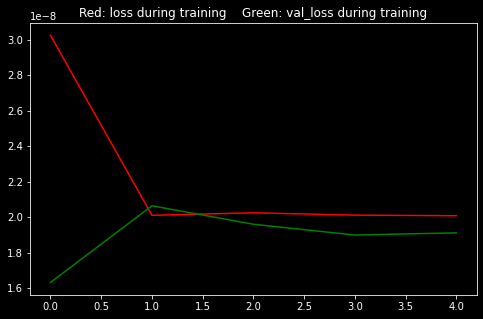

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(history['loss'], color='red')
plt.plot(history['val_loss'], color='green')
plt.title("Red: loss during training    Green: val_loss during training")

## Baseline

In [18]:
#Model statistics before training, on test set
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))
for i in range(len(results)-1):
    print(METRICS[i].name, ": {:0.4f}".format(results[i+1]))

Loss: 0.0000
root_mean_squared_error : 0.0008
mean_absolute_error : 0.0006
mean_absolute_percentage_error : 773.6189
mean_squared_logarithmic_error : 0.0000
cosine_similarity : 0.0209
logcosh : 0.0000


In [19]:
#Load saved weights
'''
Checkpoint paths for models trained in this notebook:
"/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/v4/baseline_bs32_e5.ckpt"
"/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/v4/baseline2_bs32_e5.ckpt"
"/Users/Sanjit/Repos/Predictive Analytics/model_checkpoints/v4/baseline3_bs32_e5.ckpt"
'''
#checkpoint_path = 
model.load_weights(checkpoint_path) #Define and compile the model before executing this line

In [20]:
#Model statistics after training, on test set
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))
for i in range(len(results)-1):
    print(METRICS[i].name, ": {:0.4f}".format(results[i+1]))

Loss: 0.0000
root_mean_squared_error : 0.0008
mean_absolute_error : 0.0006
mean_absolute_percentage_error : 496.4058
mean_squared_logarithmic_error : 0.0000
cosine_similarity : -0.0209
logcosh : 0.0000


## Predictions

In [38]:
#Get predictions from model using test data
predictions = model.predict(X_test)
#predictions = predictions[:, 29]
#predictions = predictions.reshape(len(predictions), 1)
print("predictions shape:", predictions.shape)

#Actual returns from test data 
actual = ob_test_ret['bid1'][LOOKBACK:len(ob_test_ret['bid1'])-HORIZON+1]
actual = np.array(actual).reshape(len(actual), 1)
print ("actual shape:", actual.shape)

#Predictions of persistence model

predictions shape: (84239, 1)
actual shape: (84239, 1)


In [36]:
THRESHOLD = 0.0025

actual_opportunities = 0
predicted_opportunities = 0
true_positives = 0

for i in range(len(predictions)):
    if actual[i][0] >= THRESHOLD:
        actual_opportunities += 1
    elif actual[i][0] <= -THRESHOLD:
        actual_opportunities += 1

for i in range(len(predictions)):
    if predictions[i][0] >= THRESHOLD:
        predicted_opportunities += 1 
    elif predictions[i][0] <= -THRESHOLD:
        predicted_opportunities += 1

for i in range(len(predictions)):
    if actual[i][0] >= THRESHOLD and predictions[i][0] >= THRESHOLD:
        true_positives += 1
    elif actual[i][0] <= -THRESHOLD and predictions[i][0] <= -THRESHOLD:
        true_positives += 1

print("Actual trade opportunities: ", actual_opportunities)
print("Predicted trade opportunities: ", predicted_opportunities)
print("Correctly identified trade opportunities: ", true_positives, "\n")

try:
    print("Precision: ", true_positives/predicted_opportunities)
except:
    print("No opportunities were predicted")
try:
    print("Sensitivity: ", true_positives/actual_opportunities)
except:
    print("No opportunities were present")
#Sensitivity is the proportion of trade opportunities correctly identified

Actual trade opportunities:  702
Predicted trade opportunities:  702
Correctly identified trade opportunities:  561 

Precision:  0.7991452991452992
Sensitivity:  0.7991452991452992


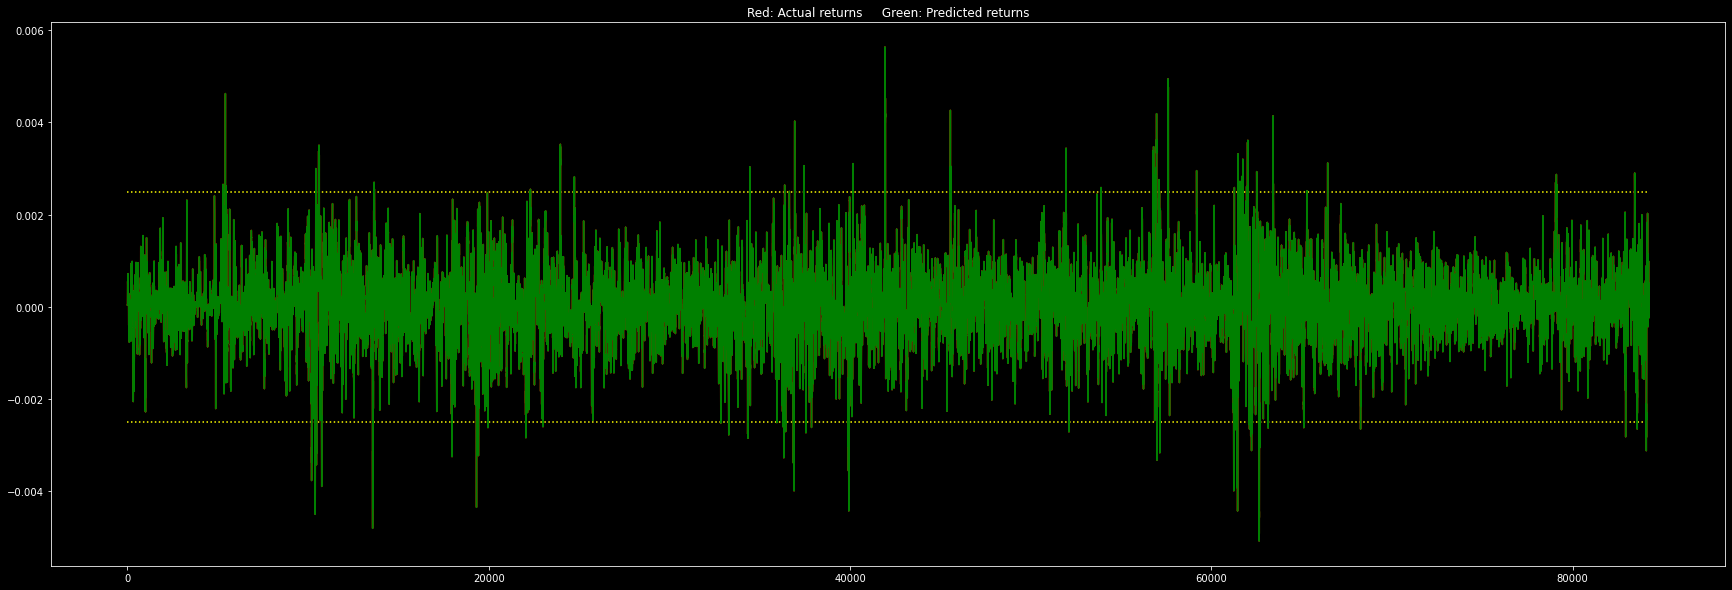

In [37]:
plt.figure(figsize=(30, 10))
plt.plot(actual, color='red')
plt.plot(predictions, color='green')
plt.title("Red: Actual returns     Green: Predicted returns")
plt.hlines(0.0025, 0, len(actual), color='yellow', linestyle='dotted')
plt.hlines(-0.0025, 0, len(actual), color='yellow', linestyle='dotted')

## Commentary
* Simply changing the data from price to returns results in a huge improvement in precision by two orders of magnitude, compared to when we were predicting prices. This is before adding any features, or modifying the dataset so that it's more balanced! Training was done for only 5 epochs, batch size 32, basic lstm model with one 100 cell lstm layer. Of course the precision is still extremely low at 2%.
    * Actually, my evaluation function was incorrect because I didn't make the elif statements mutually exclusive. Ignore this. 
* Well, I repeated the above to save the model (baseline) and fix the evaluation function. Now the precision is 83%. There's definitely a mistake somewhere.
    * I think information is leaking from the future somehow? If so it has to do with df.pct_change. Each entry in the first column of ob_train_ret is the return on a trade placed 30 seconds AGO. Right now, the X data is the returns from trades placed 44, 43, ..., 31, 30 seconds ago (15 values). The y data right now is the 30s return on a trade placed 29 seconds ago. Maybe the y data should be the 30s return on a trade placed right now. I.e. we shouldn't predict the next value in the returns series, but predict 30 values ahead. 
        * When I did this with the same parameters, the model doesn't learn at all (baseline2) It just predicts a constant return in every period. The MAPE (mean absolute percentage error) was much lower before any training than after. 
    * There was definitely look-ahead bias in baseline. E.g. the return on a trade placed 30 seconds ago contains information about the price movement across the most recent 30 seconds. With this, it's easy to predict the return on a trade placed 29 seconds ago, since the model has price information from the future. 
    * In baseline3, I'm still trying to to eliminate the look-ahead bias in the way described above, but this time I'm not asking the model to predict all the intermediate returns (30s returns on trades placed 28, 27, ..., 1 second ago) like in baseline2. baseline3 is the same as baseline2, the model doesn't learn. 
